# 1. MNIST dataset

In this tutorial, we will use `MNIST dataset` to make an algorithm that can distinguish numbers between 1~10.
First, we need to download `MNIST dataset.`

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


 There are 70,000 data points (i.e., images) in total: 55,000 training data points (mnist.train), 10,000 test data (mnist.test), and 5,000 validation data (mnist.validation).

A MNIST data point has two parts: an image of handwritten digit (`mnist.X.images`), and a corresponding label (`mnist.X.labels`). X can be either `train`, `test`, or `validation`. Each image is `28x28` pixels, which is a array of 784 numbers (i.e., 784-dimensional vector space).

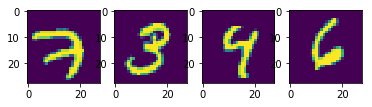

In [54]:
import matplotlib.pyplot as plt
plt.subplot(1,4,1)
plt.imshow(mnist.train.images[0].reshape([28,28]))
plt.subplot(1,4,2)
plt.imshow(mnist.train.images[1].reshape([28,28]))
plt.subplot(1,4,3)
plt.imshow(mnist.train.images[2].reshape([28,28]))
plt.subplot(1,4,4)
plt.imshow(mnist.train.images[3].reshape([28,28]))
plt.show()

# 2. Step-by-step tutorial for building a model for number recognition.

## 2.1 

To set a certain dimensional variable without specific values (i.e., *placeholder*), you use `placeholder.` To see the benefits of using `placeholder`, see https://www.tensorflow.org/get_started/mnist/beginners.

Here, we create a variable with zero row and 784 columns (784 is the number of features for MNIST dataset).

In [137]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])

Here, `None` means that a row dimsenion can be of any length.

Next, we use `Variable` as a modifiable tensor that lives in TensorFlow's graph of interacting operations.

In [138]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

`W` has a shape of [784, 10] because it has 784 pixels (features) and 10 numbers (1~10). So, the output of `W*x + b` will be the probability of correspond to the numbers between 1~10.

We use `tf.zeros` to fill `W` and `b` with zeros, but because `W` and `b` are what we are going to learn and thus change, the initial values don't matter much.

In [139]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

To implement cross entropy, we need a placeholder for the correct answers:

In [140]:
y_ = tf.placeholder(tf.float32, [None, 10])

And then we can implement the cross-entropy function

In [151]:
# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y), reduction_indices=[1]))

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

In [152]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### The above is a short for:
# optimizer = tf.train.GradientDescentOptimizer(0.5)
# train_step = optimizer.minimize(cross_entropy).`

In [153]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict = {x:batch_xs, y_:batch_ys})

# 3. Evaluating our model

In [154]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

In [155]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels}))

0.906


In [74]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9207
